# Project: Identify Fraud from Enron Email
## 1. Introduction

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we would like to build a person of interest identifier based on financial and email data. The machine learning algorithms that we are about to use include `Naive Bayes`, `Decision Tree` and `K Nearest Neighbors`.

## 2. Data Exploration

### 2.1 Outlier
When we look at the dataset, we can notice that there is one observation that is recorded with the name `TOTAL`. Obviously, it is the total value of every other observation that is from this dataset. Due to the influence of this outlier point and the fact that we only have a limited amount of points in our dataset, we would like to remove and only remove this point.

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
from IPython.display import display

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

total_features = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus',
                  'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
                  'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees',
                  'deferred_income', 'long_term_incentive', 'from_poi_to_this_person'] # email_address

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

print "Observation numbers (including 'TOTAL'): {}, Variable numbers: {}\n".format(
  len(data_dict), len(data_dict["MEYER ROCKFORD G"])-1)
print "Detailed information of TOTAL (outlier):"

print data_dict["TOTAL"]
del data_dict["TOTAL"]
print "\nObservation numbers (excluding 'TOTAL'): {}, Variable numbers: {}".format(
  len(data_dict), len(data_dict["MEYER ROCKFORD G"])-1)

Observation numbers (including 'TOTAL'): 146, Variable numbers: 20

Detailed information of TOTAL (outlier):
{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}

Observation numbers (excluding 'TOTAL'): 145, Variable numbers: 20


C:\Users\whuang67\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


After we removed the data, there are 145 observations and 20 variables (excluding variable `poi`) in our dataset. We notice that variable `email_address` is like the name (index) of each observation which can be also considered as primary key here. Hence, we will not take this one into consideration.

### 2.2 Dataset and Missing values

By default, the missing values here would be converted to 0, which may be a little confusing because we cannot tell which are missing values and which really stand for value 0. Hence, we would like to keep `nan` at the beginning and find out the discriptive statistics of our dataset.

In [2]:
my_dataset = data_dict
data = featureFormat(my_dataset, total_features, remove_NaN = False, remove_all_zeroes = False, sort_keys = True)

poi_counts = pd.Series(data[:, 0]).value_counts()
print "poi == 0: {}, poi == 1: {}".format(poi_counts[0], poi_counts[1])

poi == 0: 127, poi == 1: 18


For our response variable `poi`, 127 values of the total 145 are 0 while the rest 18 are 1. Clearly, we can read that this is a imbalanced distribution. I think that the metric `accuracy` here is absolutely not a very good metric in this classification problem. Because we can just easily build a benchmark model which says `poi` of everything is 0. And under this situation, our `accuracy` will still be 87.59% which is still impressive. Detailed discussion on metric selection will be talked about later.

In addition to this, we also would like to calculate the proportion of actual of missing values. The table below shows the proportions of missing values and zero values of different predictor variables.

In [3]:
count, count_1 = [], []
for i in range(1, len(data[0])):
    t = float(sum(np.isnan(data[:, i])))/len(data)
    t_1 = float(sum(data[:, i] == 0))/len(data)
    count.append(t)
    count_1.append(t_1)

total_predictors = ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus',
                    'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value',
                    'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees',
                    'deferred_income', 'long_term_incentive', 'from_poi_to_this_person'] # email_address

display(pd.DataFrame(np.array([count, count_1]),
                     columns = total_predictors,
                     index = ["Proportion of NaN", "Proportion of Zero"]).transpose())

,Proportion of NaN,Proportion of Zero
salary,0.351724,0.000000
to_messages,0.406897,0.000000
deferral_payments,0.737931,0.000000
total_payments,0.144828,0.000000
exercised_stock_options,0.303448,0.000000
bonus,0.441379,0.000000
restricted_stock,0.248276,0.000000
shared_receipt_with_poi,0.406897,0.000000
restricted_stock_deferred,0.882759,0.000000
total_stock_value,0.137931,0.000000


The table above clearly shows that there are very few variables which contain 0 values, but the proportions of missing values seem to be a little bit out of control. Here, we would like to keep focusing on those variables with proportions of missing values less than 0.5, which are **salary**, **to_messages**, **total_payments**, **exercised_stock_options**, **bonus**, **restricted_stock**, **shared_receipt_with_poi**, **total_stock_value**, **expenses**, **from_messages**, **other**, **from_this_person_to_poi** and **from_poi_to_this_person** 14 variables in total.

Following the source code offered by Udacity, we assume that those missing values of these 14 variables are actually value 0 and would like to convert them to value 0 here. Actually, there are some other ways to impute the missing values. For example, we can replace them with the corresponding mean or median, which will keep the central tendency of the variables with missing values.

In [4]:
total_features = ['poi', 'salary', 'to_messages', 'total_payments', 'exercised_stock_options', 'bonus',
                  'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'from_messages', 'other',
                  'from_this_person_to_poi', 'from_poi_to_this_person']
total_predictors = ['salary', 'to_messages', 'total_payments', 'exercised_stock_options', 'bonus',
                    'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'from_messages', 'other',
                    'from_this_person_to_poi', 'from_poi_to_this_person']

data = featureFormat(my_dataset, total_features, remove_all_zeroes = False, sort_keys = True)

### 2.3 New Features

Even though the outliers were removed, the variables here still keep their original skewness trend unfortunately. The variable `total_stock_value` especially gets our eyeballs because of its negative skewness. We may think if we would create a new feature by performing variable transformation, and our new feature may have a symmetric or even normal distribution. The forluma that we are about to use is:

$$NewVar = \ln{(OldVar - min(OldVar) + 1)}$$

where `NewVar` and `OldVar` stands for the variables before and after being transformed, respectively. And `min()` here stands for the mininum value of this variable. The reason that we included so many terms in the parentheses is just to make sure that our logarithm transformation is meaningful.

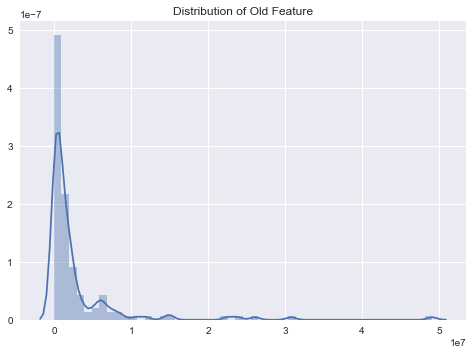

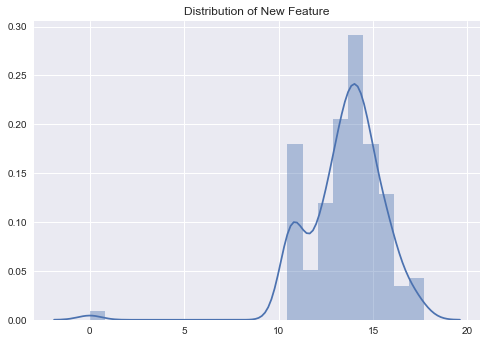

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data[:, 8])
sns.plt.title("Distribution of Old Feature")
plt.show()
x = np.log(data[:, 8] - min(data[:, 8]) + 1)
sns.distplot(x)
sns.plt.title("Distribution of New Feature")
plt.show()

The distributions of both variable `total_stock_value` and that after transformation are shown above. It looks like the distribution of the old variable is positively skewed while the transformed one may follow normal distribution. In the following parts, we will try to include both the original variable `total_stock_value` and the one after being transformed in our model.

### 2.4 Feature Selection

We have 14 variables and another one that we just created in hand, but I would like to use a subset of them. Because more features and complicated models may lead to over-fitting with good training performance but unsatisfactory testing performance. The variable importance of Decision Tree Algorithm is used here.

Two models will be drawn here, one of which contains the new feature that we just created while the other one will not include it. We would like to see if the results of two variable lists may lead to different results.

Additionally, we can see that different variables have different ranges. For example, variable `salary` varies from 0 to 1,000,000 but variable `to_messages` ranges from 0 to 5,000 only. I would also like to perform z-score transformation to scale all variables before we move on to the modle fitting part.

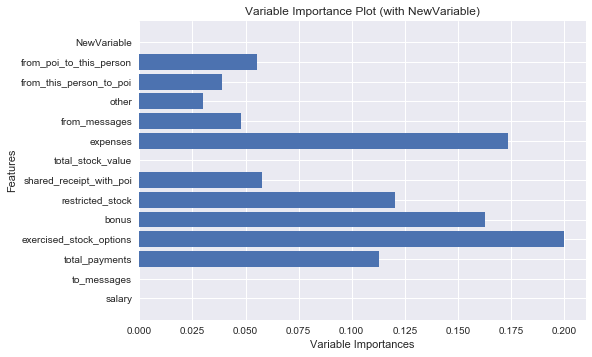

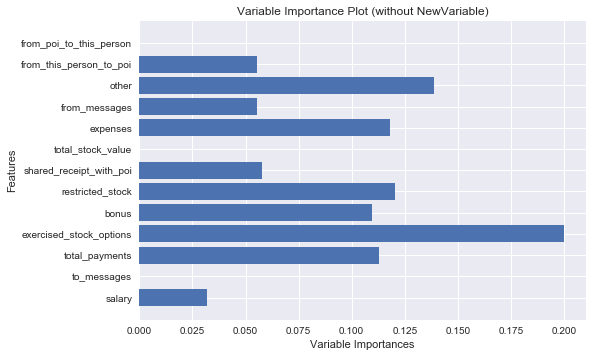

In [6]:
labels, features = targetFeatureSplit(data)
features_ = [np.append(e, f) for e, f in zip(features, x)]
# features_ = np.append(features, x, axis = 0)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
features_ = StandardScaler().fit_transform(features_)
features = StandardScaler().fit_transform(features)

clf_1 = DecisionTreeClassifier(random_state = 42).fit(features_, labels)
plt.barh(range(len(clf_1.feature_importances_)), clf_1.feature_importances_)
total_predictors.append("NewVariable")
plt.yticks(range(len(clf_1.feature_importances_)), total_predictors)
plt.title("Variable Importance Plot (with NewVariable)"); plt.xlabel("Variable Importances"); plt.ylabel("Features")
plt.show()

clf_2 = DecisionTreeClassifier(random_state = 42).fit(features, labels)
plt.barh(range(len(clf_2.feature_importances_)), clf_2.feature_importances_)
total_predictors.append("NewVariable")
plt.yticks(range(len(clf_2.feature_importances_)), total_predictors)
plt.title("Variable Importance Plot (without NewVariable)"); plt.xlabel("Variable Importances"); plt.ylabel("Features")
plt.show()

From the two plots above, we can clearly tell that different variables tend to make different contributions. Apart from variable `long_term_incentive`, all other variables are having similar variable importance values and the rank of each variables tend to be the same. We found out the actually only 8 out of the rest 13 predictors excluding `long_term_incentive` that we include that have positive variable importance value.

- Hence, I would like to start from the variable `total_payments` only which has the largest variable importance. Decision Tree and test_classifier() function will be used to help us test.
- Then, I will add the predictor with next second largest variable importance value, fit another `Decision Tree` model and calculate the test_classifier() performance of it.
- We will keep repeating the previous part until all variables with positive variable importances are included in the model.
- The model with the best performance will be chosen. We will use the corresponding variable list to fit additional models.

Especially, we notice that our **new feature** has zero contribution to our model only. Hence, we would not like to consider our new feature any more in order to have a better performance.

We will mainly focus on precision and recall here. The model with highest precision and recall will be chosen. We will use those variables to try additional algorithms to see if we can have better performances. If it is hard to make decision based on precision and recall, we will choose the one with higher overall accuracy.

$$Precision = \displaystyle{\frac{TP}{TP+FP}}$$  
$$Recall = \displaystyle{\frac{TP}{TP+FN}}$$  
$$Accuarcy = \displaystyle{\frac{TP+TN}{TP+TN+FP+FN}}$$  
where TP stands for True Positive, FP stands for False Positive, TN stands for True Negative and FN stands for False Negative. As we mentioned above, this is not a balanced classification problem because 117 out of 131 points have the `poi` being 0 while the rest 14 points are 1. Based on the formulas of `Precision` and `Recall` above, we can read that these two are good measures of the proportion of how many selected items are relevant and how many relevant items are selected, respectively (from wikipedia). If we only focus on accuracy only, the large number of True Negative predictions will seriously influence our judgement.

In [7]:
var_s = ["exercised_stock_options", "other", "restricted_stock", "expenses", "total_payments", "bonus",
         "shared_receipt_with_poi", "from_messages", "from_this_person_to_poi", "salary"]
predictor_s = ["poi"]
for e in var_s:
    predictor_s.append(e)
    data_loop = featureFormat(my_dataset, predictor_s, remove_all_zeroes = False, sort_keys = True)
    labels_loop, features_loop = targetFeatureSplit(data_loop)
    features_loop = StandardScaler().fit_transform(features_loop)
    model = DecisionTreeClassifier(random_state = 42).fit(features_loop, labels_loop)
    print test_classifier(model, my_dataset, predictor_s)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.86273	Precision: 0.27434	Recall: 0.31000	F1: 0.29108	F2: 0.30214
	Total predictions: 11000	True positives:  310	False positives:  820	False negatives:  690	True negatives: 9180

None
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.78569	Precision: 0.31772	Recall: 0.34250	F1: 0.32964	F2: 0.33724
	Total predictions: 13000	True positives:  685	False positives: 1471	False negatives: 1315	True negatives:

Based on the results above, we would like to keep **exercised_stock_options**, **other**, **restricted_stock**, **expenses** and **total_payments** these five variables eventually. Because when we keep these four features only, the corresponding `Decision Tree` model is having the highest both `Precision` and `Recall` values.

## 3. Model Fitting and Validation
### 3.1 Cross-validation
We know that different algorithms may have different parameters that we had better tune instead of assigning some random values. If we choose to use default parameters or just assign some random values, we may not get the result with the most satisfactory performance. Either under-fitting from a simple model or over-fitting from a complicated one is not a good idea.

In additional to that, if we use the whole dataset to train our models, it is also easy to get a result that fits with the training set only. A good training performance with a low testing one is definitely not something that we would like to have, either.

Hence, in this project, we would like to perform 10-fold cross-validation to help us find out the best model that we would like to have. 10-fold cross-validation will cut the whold dataset into 10 subsets randomly and equally. We will train the model based on 9 of them and test the model by using the rest. We will repeat this procedure 10 times to make sure that every subset has been tested once. Cross-validation will reduce the influence of over-fitting and at the same time help us find out the best tuning parameters with the best performance.

As we have mentioned above, this is an imbalanced classification problem. The proportion of `poi` being 0 and 1 may vary seriously, which may not be persuasive. Hence, we would like to choose Stratified Cross Validation here instead of general Cross Validation. And stratified split will be used in our model training part and validation part. Additional discussion will be made below.

### 3.2 Algorithms

In this part, I would like to fit several classifiers based on different machine learning algorithms including **Naive Bayes**, **Decision Tree** and **K Nearest Neighbor**. And different tuning parameters of the same algorithm may and will change the performance of our models dramatically.

- For **Naive Bayes** algorithm, we would not tune any parameters but use the default ones only.
- For **Decision Tree** algorithm, we would like to tune both `criterion` and `min_samples_split`. Parameter `criterion` stands for the function that measures the quality of split while parameter `min_samples_split` indicates the minimum number of samples required to split an internal node.
- For **K Nearest Neighbor** algorithm, we would like to tune `n_neighbors` which is the number of neighbors that we used while we train our classifier.

### 3.3 Metrics
Same as the previous feature selection part, we will use both precision and recall to validate these three models. The model with highest precision and recall will be chosen. We will use those variables to try additional algorithms to see if we can have better performances. If it is hard to make decision based on precision and recall, we will choose the one with higher overall accuracy.

$$Precision = \displaystyle{\frac{TP}{TP+FP}}$$  
$$Recall = \displaystyle{\frac{TP}{TP+FN}}$$  
$$Accuarcy = \displaystyle{\frac{TP+TN}{TP+TN+FP+FN}}$$  
where TP stands for True Positive, FP stands for False Positive, TN stands for True Negative and FN stands for False Negative. The importance of using these three metrics especially the first two have been discussed in the feature selection part.

- Based on the formulas above, we can read the numerator of both Precision and Recall is True Positive which stands for both actual and predicted poi being 1. The denominator of Precision is all predicted poi being 1 while the denominator of Recall is all actual poi being 1.
- Because of the large amount poi being 0 (127 vs 18), overall accuracy may not be a good metric here. That is also why we choose it as a back-up one just in case.
- The less False Positive (actual poi is 0 but we predict it to be 1) we make, the higher Precision will be.
- The less False Negative (actual poi is 1 but we predict it to be 0) we make, the higher Recall it will be.

In addtion to them, we will also choose the function `test_classifier` offered by Udacity to test these models. This function will include `Accuracy`, `Precision`, `Recall`, `F1` and `F2`. In order to calculate these, True positive, True negative, False positive and Negative are calculated, too. Here, we borrowed the function `StratifiedShuffleSplit` from [scikit learn](http://scikit-learn.org/stable/) module to split the whole dataset into training and testing sets. Parameters `folds` whose default value is set 1000 here stands for 1000 re-splitting iterations. 10% will be assigned to testing set while the rest 90% are in training set. We will concatenate 1000 training subsets together and 1000 testing subsets together. Then, we will train the model based on the whole training dataset and the algorithm that we chose again, and make prediction based on the whole testing set here.

In [8]:
predictors = ["poi", "exercised_stock_options", "other", "restricted_stock", "expenses", "total_payments"]
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, predictors, sort_keys = True)
labels_, features_ = targetFeatureSplit(data)
from sklearn.tree import DecisionTreeClassifier
features_ = StandardScaler().fit_transform(features_)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB().fit(features_, labels_)
print "The training precision and recall of Naive Bayes are {:.4f} and {:.4f} respectively.\n".format(
    precision_score(labels_, clf_NB.predict(features_)),
    recall_score(labels_, clf_NB.predict(features_)))

# Decision Tree
parameters = {"criterion": ["gini", "entropy"], "min_samples_split":[2, 4, 6, 8, 10, 12, 14]}
clf_DT = GridSearchCV(DecisionTreeClassifier(random_state = 42), parameters, cv = 10, scoring = "recall")
clf_DT.fit(features_, labels_)
print "Best Parameters for Decision Tree:"
print clf_DT.best_params_
print "The training precision and recall of Decision Tree are {:.4f} and {:.4f} respectively.\n".format(
    precision_score(labels_, clf_DT.predict(features_)),
    recall_score(labels_, clf_DT.predict(features_)))

# K Nearest Neighbors
parameters = {"n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
clf_KNN = GridSearchCV(KNeighborsClassifier(), parameters, cv = 10, scoring = "recall")
clf_KNN.fit(features_, labels_)
print "Best Parameters for K Nearest Neighbors:"
print clf_KNN.best_params_
print "The training precision and recall of KNN are {:.4f} and {:.4f} respectively.\n".format(
    precision_score(labels_, clf_KNN.predict(features_)),
    recall_score(labels_, clf_KNN.predict(features_)))

The training precision and recall of Naive Bayes are 0.4000 and 0.2222 respectively.

Best Parameters for Decision Tree:
{'min_samples_split': 2, 'criterion': 'gini'}
The training precision and recall of Decision Tree are 1.0000 and 1.0000 respectively.

Best Parameters for K Nearest Neighbors:
{'n_neighbors': 3}
The training precision and recall of KNN are 0.7143 and 0.2778 respectively.



In [9]:
clf_DT_ = clf_DT.best_estimator_
clf_KNN_ = clf_KNN.best_estimator_
print test_classifier(clf_NB, my_dataset, predictors)
print test_classifier(clf_DT_, my_dataset, predictors)
print test_classifier(clf_KNN_, my_dataset, predictors)

GaussianNB(priors=None)
	Accuracy: 0.84327	Precision: 0.34002	Recall: 0.18650	F1: 0.24088	F2: 0.20501
	Total predictions: 15000	True positives:  373	False positives:  724	False negatives: 1627	True negatives: 12276

None
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.81980	Precision: 0.33365	Recall: 0.35250	F1: 0.34282	F2: 0.34856
	Total predictions: 15000	True positives:  705	False positives: 1408	False negatives: 1295	True negatives: 11592

None
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
	Accuracy: 0.86613	Precision: 0.49504	Recall: 0.19950	F1: 0.28439	F2: 0.22655
	Total predictions: 15000	True

## 4. Summary

Based on the performances above, we can read that **Decision Tree** has their precision and recall greater than 0.3. The corresponding precision and recall that we got from `test_classifier` function are 0.33365 and 0.35250, respectively. The overall accuracy here is 0.81980.

For **Naive Bayes** and **K Nearest Neighbor** algorithm, even if the overall accuracies and precisions are slightly better than those of **Decision Tree**, but the recalls of these two are much worse.

## Reference
- Precision and recall, Wikepedia, https://en.wikipedia.org/wiki/Precision_and_recall